import module

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam


from datetime import datetime

import math
from datetime import date, timedelta
import matplotlib.pyplot as plt




Load data

In [15]:
# Load data
data = pd.read_excel('RevenuePassengerDailyUpdated_v2.xlsx')

data

,penghasilan_penumpang,tanggal,org,kode_org,des,kode_des
0,205000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
1,73000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
2,3672000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
3,56304000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
4,1500000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
...,...,...,...,...,...,...
250850,1515000,2023-06-10,AMBON,946,SURABAYA,563
250851,358000,2023-06-10,TERNATE,942,AMBON,946
250852,4920000,2023-06-11,AMBON,946,TANJUNG PRIOK,431
250853,505000,2023-06-11,AMBON,946,SURABAYA,563


Jumlah origin port

In [20]:
len(set(data['kode_org']))

65

In [ ]:
Jumlah destination port

In [22]:
len(set(data['kode_des']))

69

Jumlah rute

In [26]:
jml_rute = data.groupby(['org', 'des']).size().reset_index(name='Count')
jml_rute

,org,des,Count
0,AGATS,BAU-BAU,83
1,AGATS,KUPANG,32
2,AGATS,MAKASSAR,49
3,AGATS,MERAUKE,336
4,AGATS,SURABAYA,24
...,...,...,...
857,WASIOR,JAYAPURA,69
858,WASIOR,MAKASSAR,65
859,WASIOR,SORONG,65
860,WASIOR,SURABAYA,38


In [29]:
jml_rute.sort_values(by='Count',ascending=False)

,org,des,Count
132,BELAWAN,PULAU BATAM,3063
602,PULAU BATAM,BELAWAN,3005
419,MAKASSAR,BAU-BAU,2337
114,BAU-BAU,MAKASSAR,2259
446,MAKASSAR,SURABAYA,1968
...,...,...,...
751,TANJUNG PRIOK,SEMARANG,2
515,MERAUKE,TERNATE,2
552,NAMROLE,KISAR,2
626,SEMARANG,TANJUNG PRIOK,2


Sample data dengan count terbanyak.

In [31]:
data_sample = data[(data['org'] == 'BELAWAN') & (data['des'] == 'PULAU BATAM')]
data_sample.sort_values(by='tanggal')

,penghasilan_penumpang,tanggal,org,kode_org,des,kode_des
49,1281000,2015-08-25,BELAWAN,144,PULAU BATAM,256
50,68000,2015-08-25,BELAWAN,144,PULAU BATAM,256
51,13430000,2015-08-25,BELAWAN,144,PULAU BATAM,256
52,197820000,2015-08-25,BELAWAN,144,PULAU BATAM,256
53,254000,2015-08-25,BELAWAN,144,PULAU BATAM,256
...,...,...,...,...,...,...
250547,339000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250545,2652000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250555,2712000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250549,5508000,2023-05-23,BELAWAN,144,PULAU BATAM,256


Tampilkan data tanggal dan penghasilan penumpang

In [32]:
data_sample_process = data_sample[['tanggal','penghasilan_penumpang']]
data_sample_process

,tanggal,penghasilan_penumpang
49,2015-08-25,1281000
50,2015-08-25,68000
51,2015-08-25,13430000
52,2015-08-25,197820000
53,2015-08-25,254000
...,...,...
250552,2023-05-23,1356000
250553,2023-05-23,1632000
250554,2023-05-23,6120000
250555,2023-05-23,2712000


total penghasilan_penumpang perhari 

In [34]:
summed_data = data_sample_process.groupby('tanggal').sum().reset_index()
summed_data

,tanggal,penghasilan_penumpang
0,2015-08-25,242380000
1,2015-09-01,259189000
2,2015-09-08,235653000
3,2015-09-15,210965500
4,2015-09-22,207240500
...,...,...
258,2023-05-07,470361000
259,2023-05-14,120589000
260,2023-05-16,53118000
261,2023-05-23,27909000


In [3]:
grouped_data = data.groupby(['kode_org', 'kode_des']).size().reset_index(name='Count')
grouped_data

,kode_org,kode_des,Count
0,144,251,97
1,144,256,3063
2,144,266,989
3,144,431,1525
4,246,251,150
...,...,...,...
857,983,971,168
858,983,972,3
859,983,976,175
860,983,977,152


In [4]:
grouped_data = data.groupby(['kode_org', 'kode_des']).size().reset_index(name='Count')
grouped_data

,kode_org,kode_des,Count
0,144,251,97
1,144,256,3063
2,144,266,989
3,144,431,1525
4,246,251,150
...,...,...,...
857,983,971,168
858,983,972,3
859,983,976,175
860,983,977,152


In [5]:
data_sample = data[(data['kode_org'] == 144) & (data['kode_des'] == 256)]
data_sample

,penghasilan_penumpang,tanggal,org,kode_org,des,kode_des
49,1281000,2015-08-25,BELAWAN,144,PULAU BATAM,256
50,68000,2015-08-25,BELAWAN,144,PULAU BATAM,256
51,13430000,2015-08-25,BELAWAN,144,PULAU BATAM,256
52,197820000,2015-08-25,BELAWAN,144,PULAU BATAM,256
53,254000,2015-08-25,BELAWAN,144,PULAU BATAM,256
...,...,...,...,...,...,...
250552,1356000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250553,1632000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250554,6120000,2023-05-23,BELAWAN,144,PULAU BATAM,256
250555,2712000,2023-05-23,BELAWAN,144,PULAU BATAM,256


In [6]:
data_sample_process = data_sample[['tanggal','penghasilan_penumpang']]
data_sample_process

,tanggal,penghasilan_penumpang
49,2015-08-25,1281000
50,2015-08-25,68000
51,2015-08-25,13430000
52,2015-08-25,197820000
53,2015-08-25,254000
...,...,...
250552,2023-05-23,1356000
250553,2023-05-23,1632000
250554,2023-05-23,6120000
250555,2023-05-23,2712000


In [7]:
sorted_data = data_sample_process.sort_values(by='tanggal')
sorted_data

,tanggal,penghasilan_penumpang
49,2015-08-25,1281000
50,2015-08-25,68000
51,2015-08-25,13430000
52,2015-08-25,197820000
53,2015-08-25,254000
...,...,...
250547,2023-05-23,339000
250545,2023-05-23,2652000
250555,2023-05-23,2712000
250549,2023-05-23,5508000


In [8]:
summed_data = data_sample_process.groupby('tanggal').sum()
summed_data

#sum_by_date = data.groupby('Tanggal')['Kolom'].sum()

,penghasilan_penumpang
tanggal,
2015-08-25,242380000
2015-09-01,259189000
2015-09-08,235653000
2015-09-15,210965500
2015-09-22,207240500
...,...
2023-05-07,470361000
2023-05-14,120589000
2023-05-16,53118000


visualisasi data

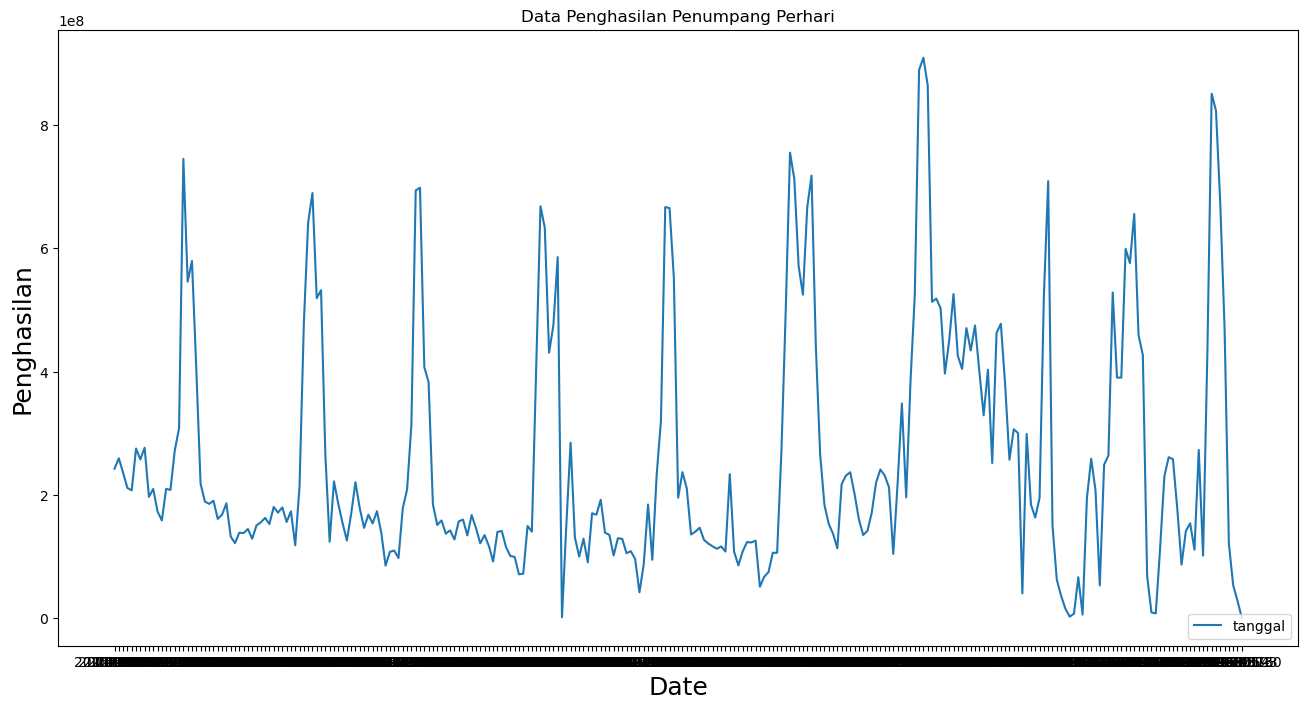

In [9]:
# plot the data

plt.figure(figsize=(16,8))
plt.title('Data Penghasilan Penumpang Perhari')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Penghasilan',fontsize=18)

plt.plot(summed_data['penghasilan_penumpang'])
#plt.plot(data_sample['penghasilan_penumpang'])

plt.legend (['tanggal','penghasilan_penumpang'],loc='lower right')

plt.show()


In [10]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(summed_data['penghasilan_penumpang'].values.reshape(-1, 1))



Applying KMEANS

In [35]:
data_sample.describe()

,penghasilan_penumpang,kode_org,kode_des
count,3.063000e+03,3063.0,3063.0
mean,2.212020e+07,144.0,256.0
std,6.250137e+07,0.0,0.0
min,-8.160000e+05,144.0,256.0
25%,7.360000e+05,144.0,256.0
50%,2.208000e+06,144.0,256.0
75%,1.123350e+07,144.0,256.0
max,6.893160e+08,144.0,256.0


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [40]:
scaler = StandardScaler()

In [42]:
data_sample[['penghasilan_penumpang_T']]=scaler.fit_transform(data_sample[['penghasilan_penumpang']])

C:\Users\User\AppData\Local\Temp\ipykernel_17768\3722383544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample[['penghasilan_penumpang_T']]=scaler.fit_transform(data_sample[['penghasilan_penumpang']])


In [43]:
data_sample

,penghasilan_penumpang,tanggal,org,kode_org,des,kode_des,penghasilan_penumpang_T
49,1281000,2015-08-25,BELAWAN,144,PULAU BATAM,256,-0.333474
50,68000,2015-08-25,BELAWAN,144,PULAU BATAM,256,-0.352885
51,13430000,2015-08-25,BELAWAN,144,PULAU BATAM,256,-0.139063
52,197820000,2015-08-25,BELAWAN,144,PULAU BATAM,256,2.811594
53,254000,2015-08-25,BELAWAN,144,PULAU BATAM,256,-0.349909
...,...,...,...,...,...,...,...
250552,1356000,2023-05-23,BELAWAN,144,PULAU BATAM,256,-0.332274
250553,1632000,2023-05-23,BELAWAN,144,PULAU BATAM,256,-0.327857
250554,6120000,2023-05-23,BELAWAN,144,PULAU BATAM,256,-0.256039
250555,2712000,2023-05-23,BELAWAN,144,PULAU BATAM,256,-0.310575


identifiying optimum cluster

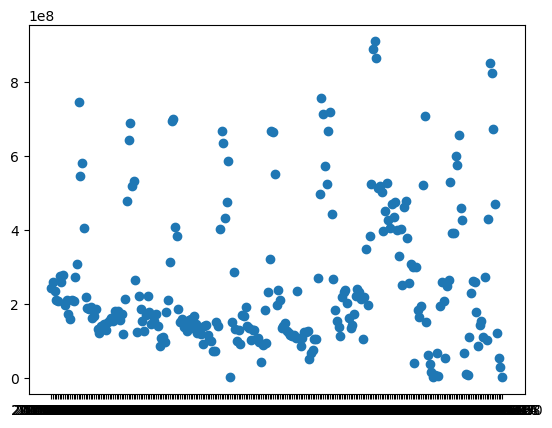

In [47]:
plt.scatter(summed_data['tanggal'],summed_data['penghasilan_penumpang'])
